# Lets transform the trained model into ONNX format

## Run this to convert

In [ ]:
%pip install -U tf2onnx
!python -m tf2onnx.convert --saved-model ./saved/tf_model/ --output ./onnx/f-crnn.onnx

## Lets now test the converted model

In [2]:
import onnxruntime as ort
import numpy as np
from time import time

tf_random_tensor = np.random.rand(1, 201, 498)
tf_random_tensor = tf_random_tensor.astype(np.float32)

ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')
outputs = ort_sess.run([], {'x': tf_random_tensor})
# Print Result
# result = outputs[0].argmax(axis=1)
print("Activations :", outputs[0][0])
# print("label :",result[0])

tik = time()
ort_sess.run([], {'x': tf_random_tensor})
tok = time()
print("Duration :{:.3f}s".format(tok-tik))

Activations : [-1.03178     0.37886485]
Duration :0.001s


### Lets test real inputs now

In [3]:
!ls ../data/LibriCount |grep  5_fe1759

5_fe1759.json
5_fe1759.wav


In [4]:
!cat ../data/LibriCount/5_fe1759.json

[{"sex": "F", "activity": [[0, 32957], [33438, 53938], [56821, 58583], [58743, 80000]], "speaker_id": 2961}, {"sex": "F", "activity": [[0, 36160], [39363, 80000]], "speaker_id": 4970}, {"sex": "F", "activity": [[0, 10054], [14699, 29594], [30395, 32156], [32957, 34719], [35199, 56981], [57301, 80000]], "speaker_id": 4992}, {"sex": "M", "activity": [[0, 44489], [47852, 76360]], "speaker_id": 61}, {"sex": "M", "activity": [[0, 28152], [30395, 31836], [31996, 80000]], "speaker_id": 8230}]

In this audio, there is 2 M and 3 F

In [25]:
import scipy.signal
from scipy.io import wavfile

FFT_N_PERSEG = 400
FFT_N_OVERLAP = 240
FFT_WINDOW_TYPE = "tukey"
EPS = 1e-8

file = "../data/LibriCount/5_fe1759.wav"

sample_rate, clip = wavfile.read(file)
_, _, fft = scipy.signal.spectrogram(clip,
                                            fs = sample_rate,
                                            nperseg = FFT_N_PERSEG,
                                            noverlap = FFT_N_OVERLAP,
                                            window = FFT_WINDOW_TYPE
                                            )

fft = fft / (np.linalg.norm(fft, axis=0, keepdims=True) + EPS)
fft = fft.astype(np.float32)
fft = fft[None, :, :] # Add the batch dimension = 1
fft.shape

(1, 201, 498)

In [7]:
ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')

tik = time()
outputs = ort_sess.run([], {'x': fft})
tok = time()
print("Activations [M, F] :", outputs[0][0])
print("Duration :{:.3f}s".format(tok-tik))

Activations [M, F] : [3.2492657 2.6321983]
Duration :0.004s


If we round the activation values we get 3 Males and 3 Females, (Instead of 2 M and 3 F)

### Lets now use microphone

You might need this :
```
$ pip install sounddevice
$ sudo apt-get install libportaudio2
```

In [233]:
import sounddevice as sd    
from scipy.io.wavfile import write

assert sample_rate == 16000,"Sample rate must be 16000"

fs = sample_rate  # Sample rate
seconds = 5  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
myrecording = myrecording[:,0]
write('tmp/audio_recorded.wav', fs, myrecording)  # Save as WAV file 

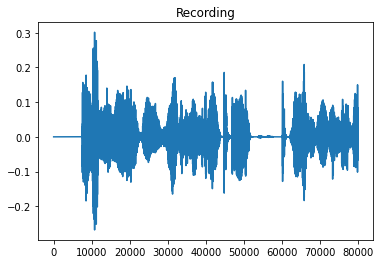

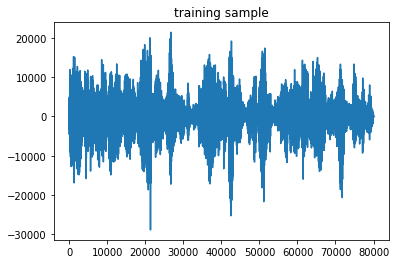

In [234]:
import matplotlib.pyplot as plt
plt.plot(myrecording)
plt.title("Recording")
plt.show()
plt.plot(clip)
plt.title("training sample")
plt.show()

As we can see the two audio don't have the same amplitude, but I think normalization step will solve this problem

In [235]:
assert clip.shape == myrecording.shape, "The recorded audio doesn't have the same shape as the training clip" 

In [236]:
_, _, fft_rec = scipy.signal.spectrogram(myrecording,
                                        fs = sample_rate,
                                        nperseg = FFT_N_PERSEG,
                                        noverlap = FFT_N_OVERLAP,
                                        window = FFT_WINDOW_TYPE
                                        )

fft_rec = fft_rec / (np.linalg.norm(fft_rec, axis=0, keepdims=True) + EPS)
fft_rec = fft_rec.astype(np.float32)
fft_rec = fft_rec[None, :, :] # Add the batch dimension = 1
fft_rec.shape

(1, 201, 498)

Text(0.5, 1.0, 'training spectrogram')

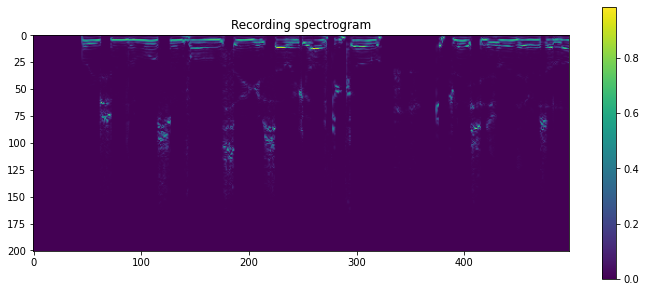

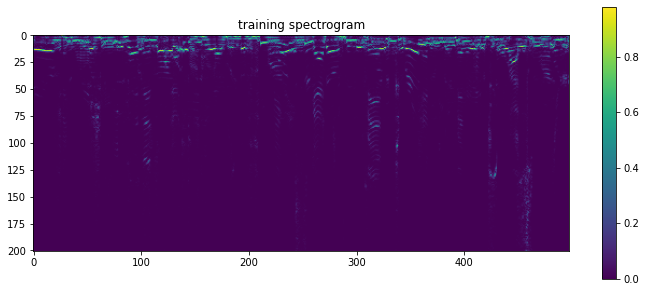

In [237]:
plt.figure(figsize=(12, 5))
plt.imshow(fft_rec[0,:,:])
plt.colorbar()
plt.title("Recording spectrogram")

plt.figure(figsize=(12, 5))
plt.imshow(fft[0,:,:])
plt.colorbar()
plt.title("training spectrogram")

The expected, the normalization renders the spectrogram to the same scale

In [238]:
ort_sess = ort.InferenceSession('onnx/f-crnn.onnx')

tik = time()
outputs = ort_sess.run([], {'x': fft_rec})
tok = time()
print("Activations [M, F] :", outputs[0][0])
print("Total amount of people :", round(outputs[0][0].sum()))
print("Duration :{:.3f}s".format(tok-tik))

Activations [M, F] : [0.20461112 0.734232  ]
Total amount of people : 1
Duration :0.001s
